# <center>Bike Sharing Assignment

## 1. Introduction

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is trying to accelerate its revenue as soon as the ongoing lockdown comes to an end.

A consulting company is approached to understand the factors on which the demand for these shared bikes depends. The company wants to know:

- Which variables are significant in predicting the demand for shared bikes?
- How well those variables describe the bike demands?

In this Assignment, we will use *Multiple Linear Regression* to build a model and understand how the demand varies with the features of dataset

## 2. Business Objective

* To model the demand for shared bikes with the available independent variables.
* To understand how exactly the demands vary with different features.

## 3. Initialize

### 3.1 Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#For Modelling
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### 3.2 Change default settings

In [4]:
import warnings
warnings.filterwarnings('ignore')

## 4. Data Reading and Understanding

### 4.1 Import Data

In [5]:
df = pd.read_csv('day.csv', index_col=0, low_memory=False)

### 4.2 Explore Data

In [6]:
#Check for data and null
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 91.2+ KB


In [7]:
#Rename columns for clarity
df.rename(columns={'dteday':'Date',
                   'season':'Season',
                   'yr':'Year', 
                   'mnth':'Month',
                   'holiday':'Holiday',
                   'weekday':'Day',
                   'workingday':'Working_Day',
                   'weathersit':'Weather',
                   'temp':'Temperature', 
                   'atemp':'Apparent_Temperature',
                   'hum': 'Humidity', 
                   'windspeed': 'Windspeed',
                   'casual':'Casual_Users',
                   'registered':'Registered_Users',
                   'cnt':'User_Demand'}, inplace=True)

In [8]:
df.head()

,Date,Season,Year,Month,Holiday,Day,Working_Day,Weather,Temperature,Apparent_Temperature,Humidity,Windspeed,Casual_Users,Registered_Users,User_Demand
instant,,,,,,,,,,,,,,,
1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


**Convert to Categorical**<br>
We convert the numerical labels to Appropriate String labels.

In [9]:
# Convert month to names
df['Month'] = pd.to_datetime(df['Month'], format='%m').dt.month_name()
catcols = ['Season', 'Year','Month','Holiday','Day','Working_Day','Weather']
numcols = [col for col in df.columns if col not in catcols]
df[catcols] = df[catcols].astype("category")
#Convert numeric levels to Nominal labels
df.Season = df.Season.cat.rename_categories({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})
df.Weather = df.Weather.cat.rename_categories({1:'Clear_Skies', 2:'Mist_or_Cloudy', 3:'Light_Rain_or_Snow', 4:'Heavy_Rain_or_Snow'})
df['Day'] = df.Day.cat.rename_categories({0:'Sunday', 1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday'})

In [10]:
df.head()

,Date,Season,Year,Month,Holiday,Day,Working_Day,Weather,Temperature,Apparent_Temperature,Humidity,Windspeed,Casual_Users,Registered_Users,User_Demand
instant,,,,,,,,,,,,,,,
1,01-01-2018,Spring,0,January,0,Saturday,0,Mist_or_Cloudy,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,Spring,0,January,0,Sunday,0,Mist_or_Cloudy,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,Spring,0,January,0,Monday,1,Clear_Skies,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,Spring,0,January,0,Tuesday,1,Clear_Skies,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,Spring,0,January,0,Wednesday,1,Clear_Skies,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [11]:
df[numcols].describe()

,Temperature,Apparent_Temperature,Humidity,Windspeed,Casual_Users,Registered_Users,User_Demand
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [12]:
df.describe(include = ['object', 'category'])

,Date,Season,Year,Month,Holiday,Day,Working_Day,Weather
count,730,730,730,730,730,730,730,730
unique,730,4,2,12,2,7,2,3
top,01-01-2018,Fall,0,August,0,Sunday,1,Clear_Skies
freq,1,188,365,62,709,105,499,463


-------------------------------------------------------------------------------------
<font color="green">**Insights**</font>
1. Since mean and Median are almost same the data is without any outliers
2. There are no missing Values.
-------------------------------------------------------------------------------------

### 4.3 Visualise Data

#### 4.3.1 Visualising Numeric Variables

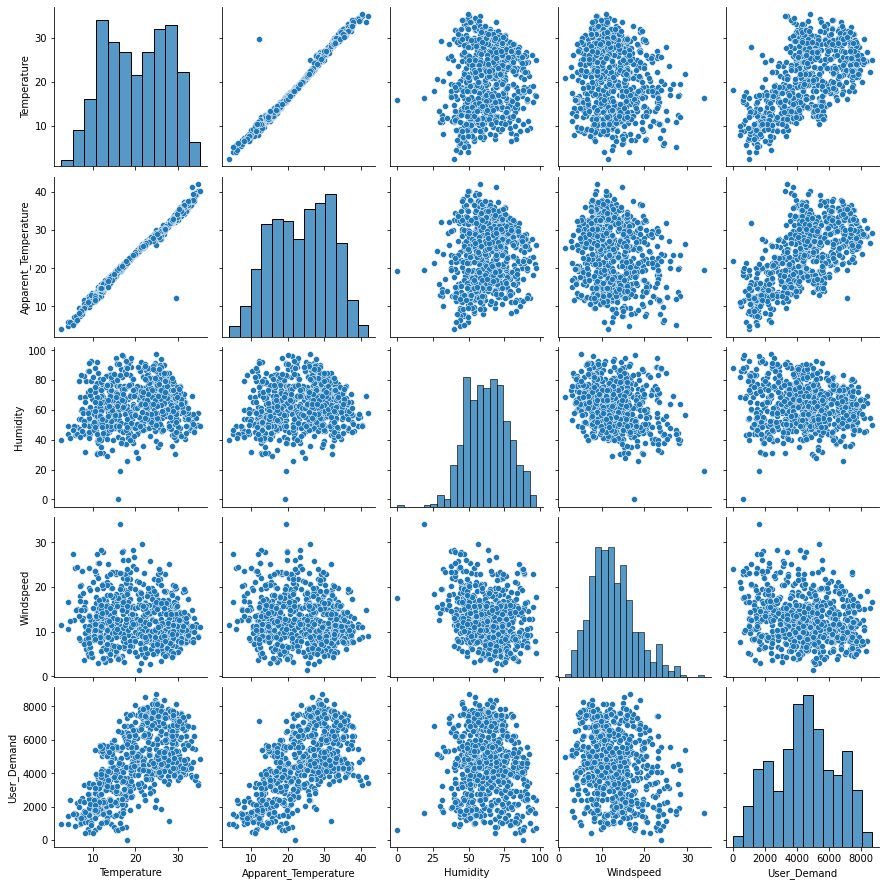

In [13]:
#For checking out the relationship
sns.pairplot(df[numcols].drop(columns=['Registered_Users','Casual_Users']))
plt.show()
#plt.savefig('test.png', bbox_inches='tight')

-------------------------------------------------------------------------------------
<font color="green">**Insights**</font>
1. Apparent Temperature and Temperature and Highly correlated as expected.
2. The user_Demand is correlated with Temperature and Apparent Temperature
-------------------------------------------------------------------------------------

#### 4.3.2 Visualising Categorical Variables

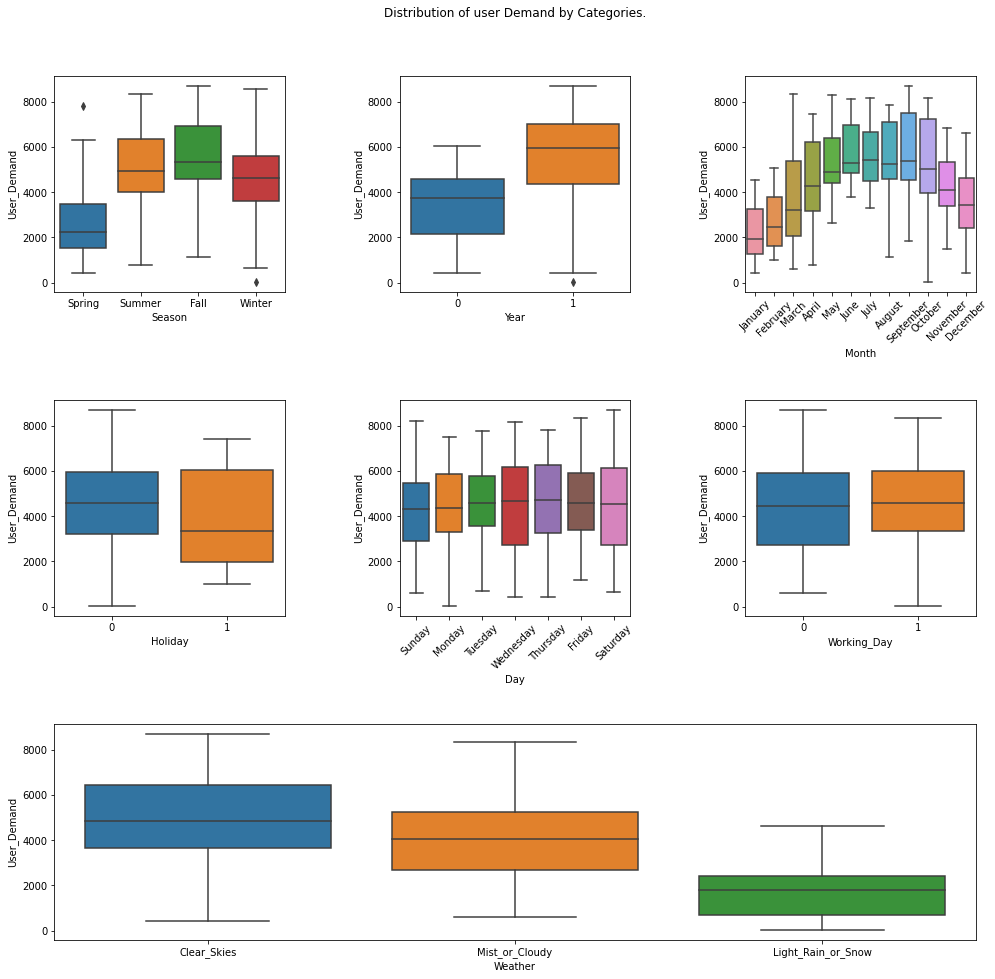

In [14]:
fig, axs = plt.subplots(3,3, figsize=(16, 12))
axs= axs.flatten()
sns.boxplot(x='Season', y='User_Demand', data=df, ax=axs[0])
sns.boxplot(x='Year', y='User_Demand', data=df, ax=axs[1])
sns.boxplot(x='Month', y='User_Demand', data=df, ax=axs[2], order=['January','February','March',
                                                                   'April','May','June','July',
                                                                   'August','September','October',
                                                                   'November','December'])
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)
sns.boxplot(x='Holiday', y='User_Demand', data=df, ax=axs[3])
sns.boxplot(x='Day', y='User_Demand', data=df, ax=axs[4])
axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation=45)
sns.boxplot(x='Working_Day', y='User_Demand', data=df, ax=axs[5])
plt.subplot(3,1,3)
sns.boxplot(x = 'Weather', y = 'User_Demand', data=df)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=-0.1,hspace=0.5, wspace=0.5)
_=plt.suptitle('Distribution of user Demand by Categories.')
plt.show()
#plt.savefig('test.png', bbox_inches='tight')

-------------------------------------------------------------------------------------
<font color="green">**Insights**</font>
1. Average User demand rises during summer and fall. It decreases in spring.
2. Average Demand is more for 2019.
3. Average Demand increases during July to Septmenber.
4. Average Demand is more for non Holidays.
5. Average Demand remains same through out the week.
6. Average Demand inccreases for Clear skies and reduces for Light rain or snow.
-------------------------------------------------------------------------------------

In [15]:
#Function to plot stacked bar plot with percentage value annotated.
def mybarplot(col, data, ax):
    ct = data[['Registered_Users','Casual_Users',col]].groupby(by=col).mean()
    ax=ct.plot(kind='bar', stacked=True, ax=ax, rot=60)
    ct['PercentageCasual']=ct.apply(lambda row: row['Casual_Users']/row.sum() *100, axis=1)
    for i in range(len(ct)):
        x = ax.patches[i].get_x() + ax.patches[i].get_width()/2
        y = ax.patches[i].get_height() + ax.patches[i+len(ct)].get_height()
        ax.annotate(f"{ct.loc[ct.index[i],'PercentageCasual']:0.2f}%", (x , y * 1.005), ha='center')

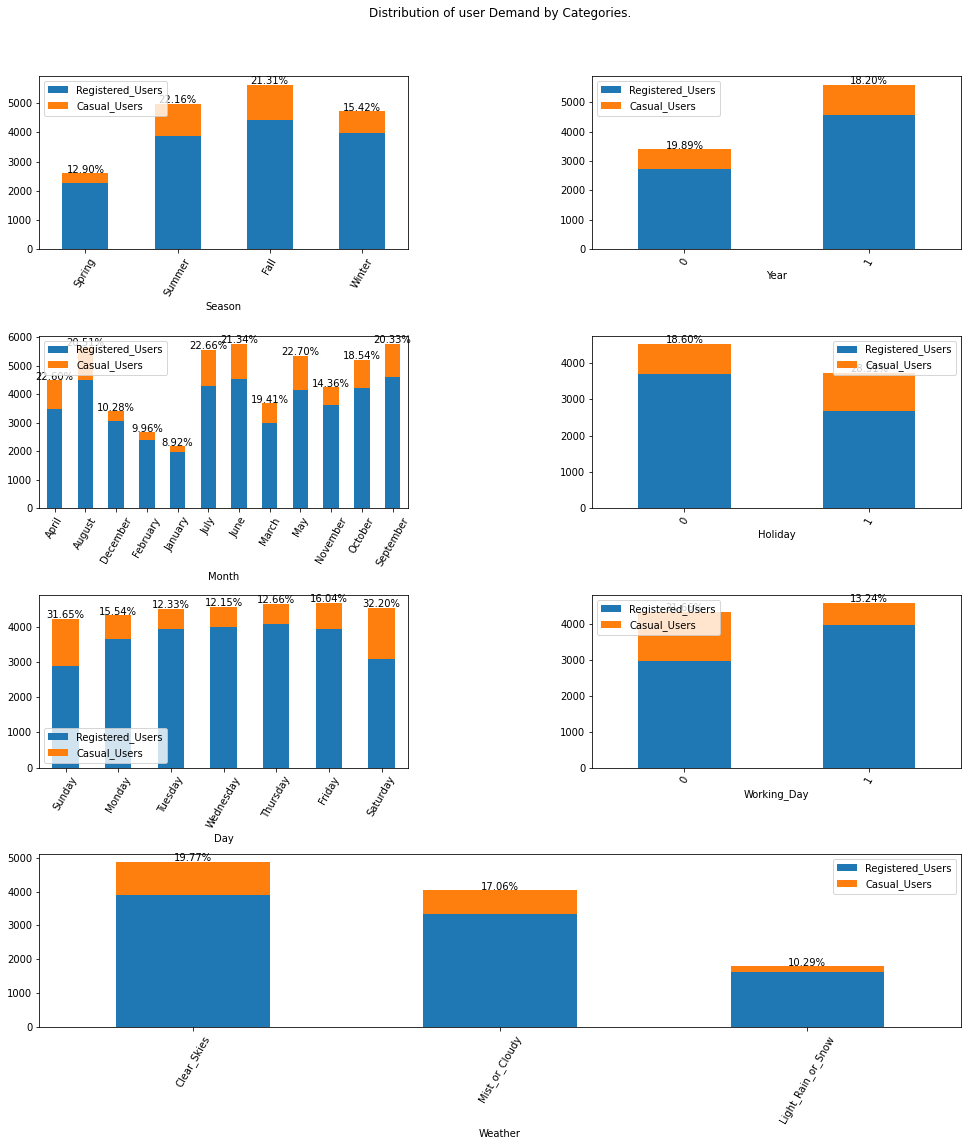

In [16]:
fig, axs = plt.subplots(4,2, figsize=(16, 12))
axs= axs.flatten()
mybarplot(col='Season', data=df, ax=axs[0])
mybarplot(col='Year', data=df, ax=axs[1])
mybarplot(col='Month', data=df, ax=axs[2])
mybarplot(col='Holiday', data=df, ax=axs[3])
mybarplot(col='Day', data=df, ax=axs[4])
mybarplot(col='Working_Day', data=df, ax=axs[5])
ax = plt.subplot(4,1,4)
mybarplot(col = 'Weather', data=df, ax=ax)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=-0.2,hspace=0.5, wspace=0.5)
_=plt.suptitle('Distribution of user Demand by Categories.')
plt.show()

-------------------------------------------------------------------------------------
<font color="green">**Insights**</font>
1. The Casual users increased for days with clear skies.
2. The Registered users reduced during weekends. However the Casual users increased for the weekend. The total Demand remains the same.
3. The percentage of casual users increases for holidays.
-------------------------------------------------------------------------------------

<AxesSubplot:xlabel='instant'>

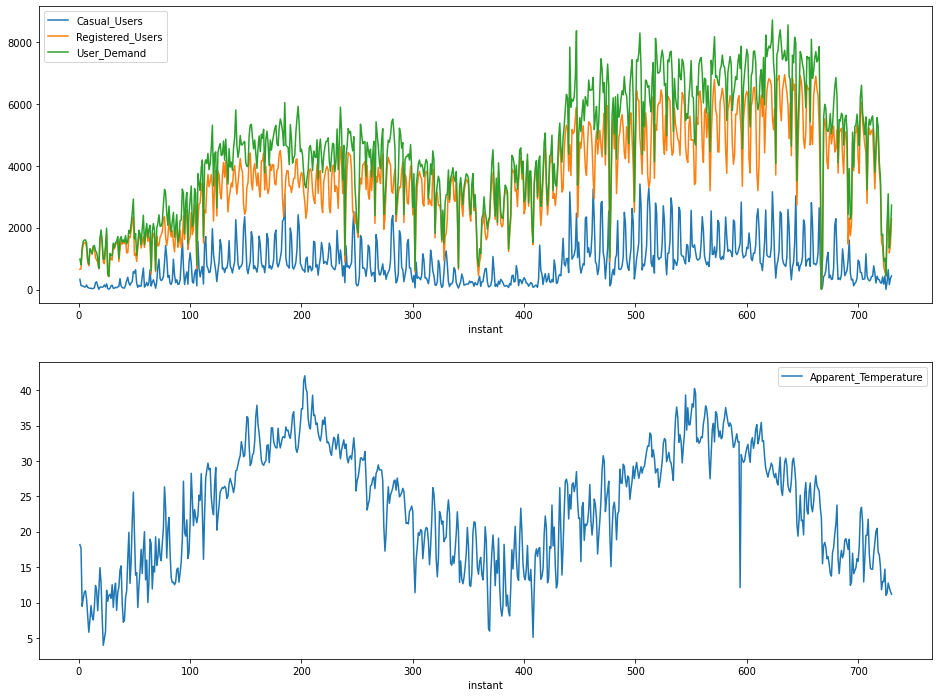

In [17]:
fig, axs = plt.subplots(2,1, figsize=(16, 12))
axs = axs.flatten()
df[['Casual_Users','Registered_Users','User_Demand']].plot(ax=axs[0])
df[['Apparent_Temperature']].plot(ax=axs[1])

In [18]:
import matplotlib.ticker as plticker

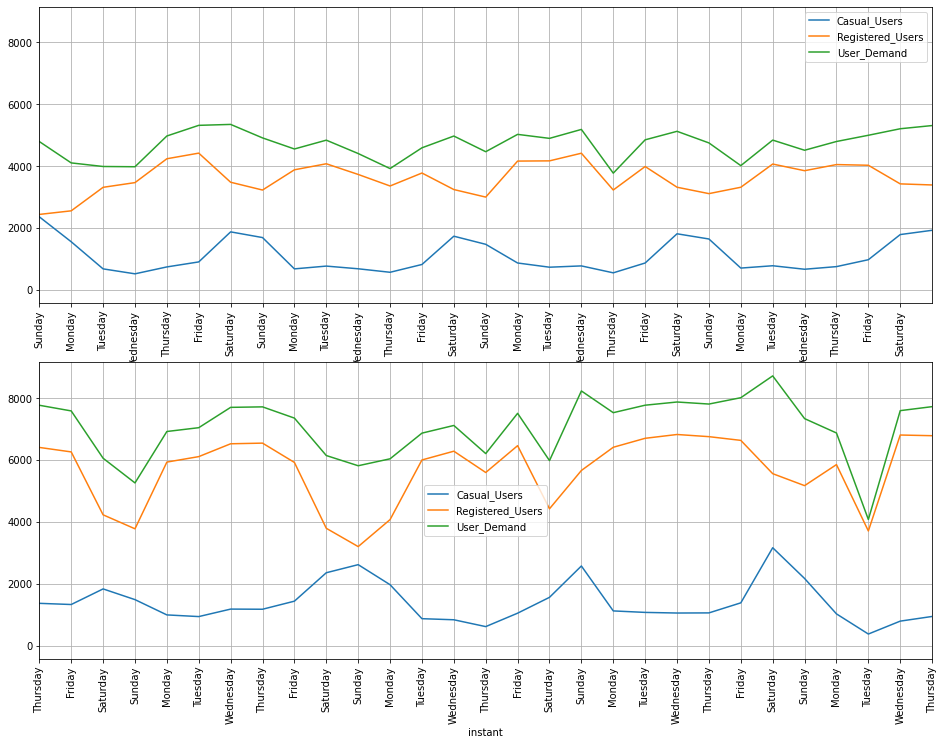

In [19]:
fig, axs = plt.subplots(2,1, figsize=(16, 12))
axs = axs.flatten()
df[['Casual_Users','Registered_Users','User_Demand']].plot(ax=axs[0])
df[['Casual_Users','Registered_Users','User_Demand']].plot(ax=axs[1])
axs[0].set_xlim(149,177)
axs[1].set_xlim(600,614)
axs[0].grid(which='both', axis='both')
axs[0].set_xticks(np.arange(149,177))
_=axs[0].set_xticklabels(df.loc[149:176, 'Day'], rotation=90)
axs[1].grid(which='both', axis='both')
axs[1].set_xticks(np.arange(600,629))
_=axs[1].set_xticklabels(df.loc[600:628, 'Day'], rotation=90)
#loc = plticker.MultipleLocator(base=7)
#loc2 = plticker.MultipleLocator(base=1)
#axs[0].xaxis.set_major_locator(loc)
#axs[0].xaxis.set_minor_locator(loc2)

-------------------------------------------------------------------------------------
<font color="green">**Insights**</font>
1. There seems to be a 7 day periiodicity in casual users and registered users.
2. The total demand also showed a slight periodicity of 7 days.
-------------------------------------------------------------------------------------

## 5. Data Preparation

### 5.1 Remove unnecessary Features

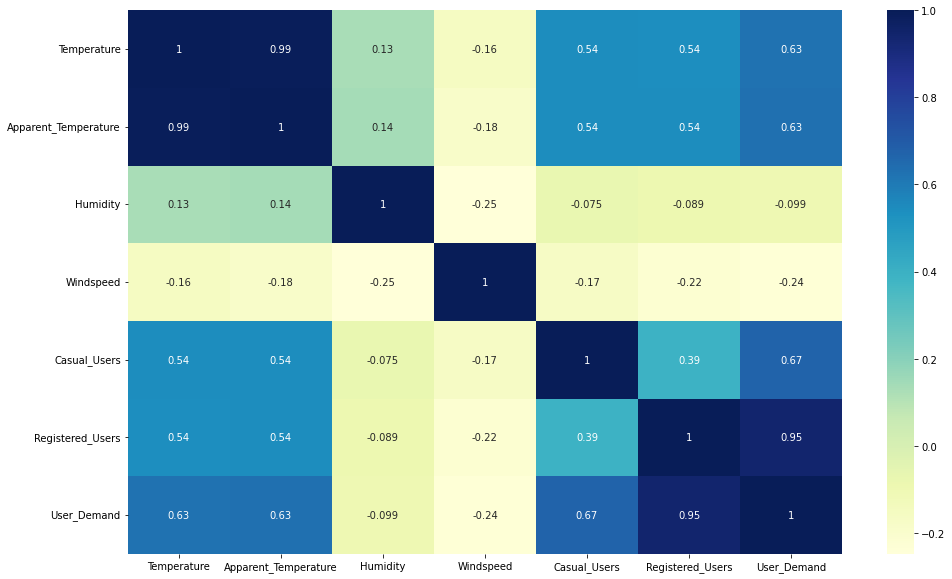

In [20]:
# Let's check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (16, 10))
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")
plt.show()

In [21]:
#We Remove Casual_users, and Registered Users as they are a part of output variable
df2 = df.drop(columns=['Casual_Users', 'Registered_Users'])

### 5.2 Add Dummy Variables

In [22]:
status = pd.get_dummies(df2[['Month', 'Day', 'Season', 'Weather']], drop_first=True, prefix=None)
df2 = pd.concat([df2, status], axis=1)
df2 = df2.drop(columns=['Date','Weather','Season','Day','Month'])
df2.head()

,Year,Holiday,Working_Day,Temperature,Apparent_Temperature,Humidity,Windspeed,User_Demand,Month_August,Month_December,...,Day_Tuesday,Day_Wednesday,Day_Thursday,Day_Friday,Day_Saturday,Season_Summer,Season_Fall,Season_Winter,Weather_Mist_or_Cloudy,Weather_Light_Rain_or_Snow
instant,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,...,1,0,0,0,0,0,0,0,0,0
5,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,...,0,1,0,0,0,0,0,0,0,0


### 5.3 Split Data

In [23]:
#Split data to 80-20%
df_train, df_test = train_test_split(df2, train_size = 0.8, test_size = 0.2, random_state = 100)

### 5.4 Scale Features 

**We create a min max scaler ans scale the continuous numeric varaibles.**

In [24]:
numcols=['Apparent_Temperature','Temperature','Humidity','Windspeed']#,'User_Demand']
scaler = MinMaxScaler()
df_train[numcols] = scaler.fit_transform(df_train[numcols])
df_train.describe()

,Temperature,Apparent_Temperature,Humidity,Windspeed,User_Demand,Month_August,Month_December,Month_February,Month_January,Month_July,...,Day_Tuesday,Day_Wednesday,Day_Thursday,Day_Friday,Day_Saturday,Season_Summer,Season_Fall,Season_Winter,Weather_Mist_or_Cloudy,Weather_Light_Rain_or_Snow
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,...,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,0.537414,0.513175,0.649499,0.319463,4505.267123,0.090753,0.087329,0.073630,0.087329,0.075342,...,0.133562,0.154110,0.135274,0.123288,0.150685,0.246575,0.251712,0.250000,0.342466,0.027397
std,0.225336,0.211663,0.144219,0.168114,1958.617712,0.287504,0.282558,0.261392,0.282558,0.264169,...,0.340472,0.361363,0.342309,0.329049,0.358048,0.431387,0.434369,0.433384,0.474941,0.163378
min,0.000000,0.000000,0.000000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.340113,0.331819,0.535852,0.199177,3070.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.545191,0.530558,0.653714,0.294764,4566.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.736512,0.690521,0.752361,0.410413,6035.750000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.250000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,8714.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**We will check the relation ship of the variables.***

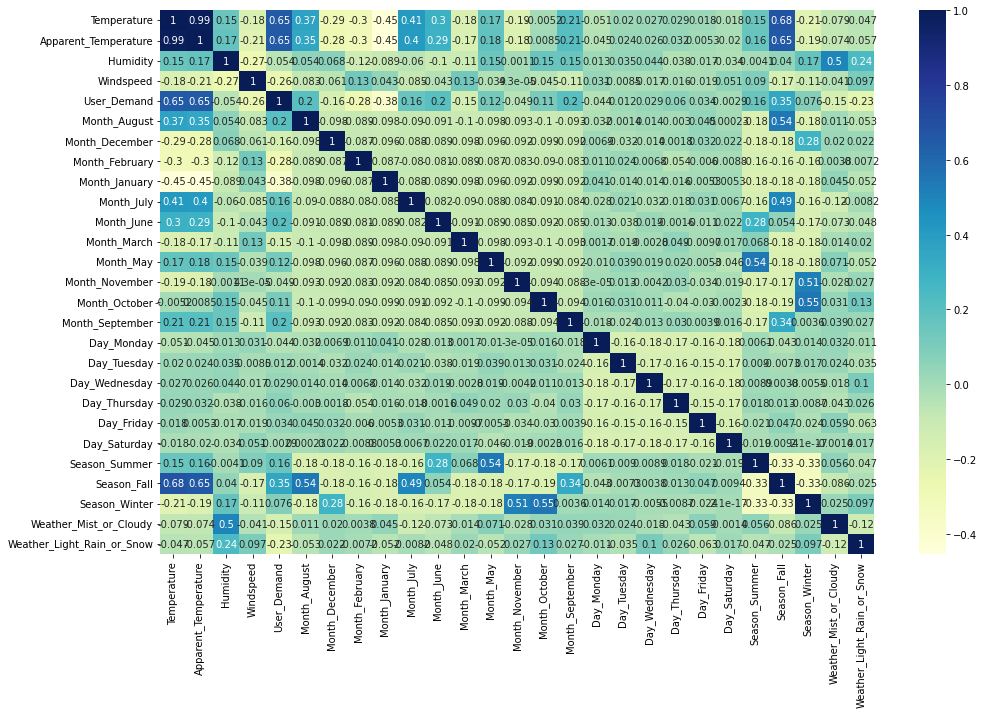

In [25]:
# Let's check the correlation coefficients to see which variables are highly correlated
plt.figure(figsize = (16, 10))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

**X-Y Split**

In [26]:
y_train = df_train.pop('User_Demand')
X_train_main = df_train

## 6. Build Model 

In [27]:
#Function to create a table with both VIF and P-values for easy coomparison of features
def evaluate_model(X, lr_model):
    vif = pd.DataFrame(index=lr_model.params.index)
    vif['VIF'] = [round(variance_inflation_factor(X.values, i),3) for i in range(X.shape[1])]

    vif['Coefficient'] = round(lr_model.params,3)
    vif['P-Values'] = round(lr_model.pvalues, 3)
    vif = vif.sort_values(by = ["VIF",'P-Values','Coefficient'],ascending = [False,False,True])
    print(f'R-Squared : {lr_model.rsquared:0.3f}    Adjusted R-Squared :{lr_model.rsquared_adj:0.3f} ')
    print( vif)

**Model 1**

We remove apparent temperature as it is highly correlated with temperature.

In [28]:
X_train1 = X_train_main.drop('Apparent_Temperature',axis=1)

In [29]:
# Running RFE with the output number of the variable equal to 13
lm1 = LinearRegression()
lm1.fit(X_train1, y_train)
rfe = RFE(lm1, n_features_to_select=13)             # running RFE
rfe = rfe.fit(X_train1, y_train)

In [30]:
list(zip(X_train1.columns,rfe.support_,rfe.ranking_))

[('Year', True, 1),
 ('Holiday', True, 1),
 ('Working_Day', False, 2),
 ('Temperature', True, 1),
 ('Humidity', True, 1),
 ('Windspeed', True, 1),
 ('Month_August', False, 10),
 ('Month_December', False, 4),
 ('Month_February', False, 6),
 ('Month_January', False, 5),
 ('Month_July', True, 1),
 ('Month_June', False, 12),
 ('Month_March', False, 16),
 ('Month_May', False, 9),
 ('Month_November', False, 3),
 ('Month_October', False, 11),
 ('Month_September', True, 1),
 ('Day_Monday', False, 7),
 ('Day_Tuesday', False, 8),
 ('Day_Wednesday', False, 14),
 ('Day_Thursday', False, 15),
 ('Day_Friday', False, 13),
 ('Day_Saturday', True, 1),
 ('Season_Summer', True, 1),
 ('Season_Fall', True, 1),
 ('Season_Winter', True, 1),
 ('Weather_Mist_or_Cloudy', True, 1),
 ('Weather_Light_Rain_or_Snow', True, 1)]

In [31]:
#Select columns given by RFE
col = X_train1.columns[rfe.support_]
X_train1 = X_train1[col]
#Train the model using columns given by rfe
X_train1 = sm.add_constant(X_train1)
lm1 = sm.OLS(y_train, X_train1).fit() 
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:            User_Demand   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     240.4
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          1.99e-221
Time:                        20:05:09   Log-Likelihood:                -4709.0
No. Observations:                 584   AIC:                             9446.
Df Residuals:                     570   BIC:                             9507.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [32]:
evaluate_model(X_train1, lm1)

R-Squared : 0.846    Adjusted R-Squared :0.842 
                               VIF  Coefficient  P-Values
const                       47.530     1867.489     0.000
Season_Fall                  5.108      513.163     0.002
Temperature                  3.554     4737.403     0.000
Season_Summer                2.637      984.130     0.000
Humidity                     1.931    -1461.301     0.000
Season_Winter                1.906     1410.057     0.000
Weather_Mist_or_Cloudy       1.587     -452.114     0.000
Month_July                   1.507     -495.552     0.001
Month_September              1.285      661.035     0.000
Weather_Light_Rain_or_Snow   1.242    -2104.110     0.000
Windspeed                    1.194    -1564.160     0.000
Year                         1.033     1969.907     0.000
Holiday                      1.019     -871.306     0.000
Day_Saturday                 1.013      164.824     0.069


**We remove Season_Fall as the VIF is 5.107**

In [33]:
X_train1.drop('Season_Fall',axis=1, inplace=True)                
lm1 = sm.OLS(y_train, X_train1).fit() 
evaluate_model(X_train1, lm1)

R-Squared : 0.843    Adjusted R-Squared :0.840 
                               VIF  Coefficient  P-Values
const                       47.398     1831.775     0.000
Humidity                     1.917    -1542.442     0.000
Temperature                  1.601     5349.112     0.000
Weather_Mist_or_Cloudy       1.580     -435.340     0.000
Month_July                   1.448     -405.149     0.006
Season_Summer                1.354      725.193     0.000
Season_Winter                1.268     1228.268     0.000
Weather_Light_Rain_or_Snow   1.237    -2061.841     0.000
Month_September              1.193      770.962     0.000
Windspeed                    1.185    -1618.481     0.000
Year                         1.028     1956.133     0.000
Holiday                      1.018     -890.852     0.000
Day_Saturday                 1.012      168.426     0.065


In [34]:
X_train1.drop('Day_Saturday',axis=1, inplace=True)                
lm1 = sm.OLS(y_train, X_train1).fit() 
evaluate_model(X_train1, lm1)

R-Squared : 0.842    Adjusted R-Squared :0.839 
                               VIF  Coefficient  P-Values
const                       47.012     1869.007     0.000
Humidity                     1.914    -1563.949     0.000
Temperature                  1.601     5346.589     0.000
Weather_Mist_or_Cloudy       1.580     -431.899     0.000
Month_July                   1.448     -401.515     0.007
Season_Summer                1.354      722.885     0.000
Season_Winter                1.268     1229.311     0.000
Weather_Light_Rain_or_Snow   1.236    -2053.724     0.000
Month_September              1.192      777.573     0.000
Windspeed                    1.183    -1603.063     0.000
Year                         1.026     1951.070     0.000
Holiday                      1.013     -918.289     0.000


**The model seems to be good with good VIFs and P-values and good R2** Let us checkout the model summary

In [35]:
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            User_Demand   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     277.7
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          3.98e-221
Time:                        20:05:09   Log-Likelihood:                -4715.5
No. Observations:                 584   AIC:                             9455.
Df Residuals:                     572   BIC:                             9508.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1869.0074    222.792      8.389      0.000    1431.417    2306.598
Year                        1951.0703     65.858     29.626      0.000    1821.718    2080.423
Holiday                     -918.2886    200.328     -4.584      0.000   -1311.757    -524.820
Temperature                 5346.5887    182.589     29.282      0.000    4987.961    5705.216
Humidity                   -1563.9490    311.988     -5.013      0.000   -2176.731    -951.167
Windspeed                  -1603.0635    210.416     -7.619      0.000   -2016.346   -1189.781
Month_July                  -401.5149    148.125     -2.711      0.007    -692.451    -110.579
Month_September              777.5727    130.411      5.962      0.000     521.430    1033.716
Season_Summer                722.8855     87.730      8.240      0.000     550.574     895.197
Season_Winter               1229.3111     84.494     14.549      0.000    1063.356    1395.267
Weather_Mist_or_Cloudy      -431.8995     86.060     -5.019      0.000    -600.932    -262.867
Weather_Light_Rain_or_Snow -2053.7242    221.342     -9.279      0.000   -2488.467   -1618.982
==============================================================================
Omnibus:                       67.355   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.091
Skew:                          -0.666   Prob(JB):                     6.26e-31
Kurtosis:                       4.986   Cond. No.                         18.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**This is our Model one.**

**Model-2**

Here we remove some variables:
 - We Remove Temperature, Windspeed and Humidity as they are used in calculation of Apparent Temperature.
 - We remove Season_fall as it is correlated with Apparent temperature.
 - We remove Seasons as it maybe coorelated with Months.

In [36]:
X_train2 = X_train_main.drop(['Temperature', 'Windspeed', 'Humidity','Season_Fall','Season_Winter','Season_Summer'],axis=1)

In [37]:
# Running RFE with the output number of the variable equal to 13
lm2 = LinearRegression()
lm2.fit(X_train2, y_train)
rfe = RFE(lm2, n_features_to_select=13)             # running RFE
rfe = rfe.fit(X_train2, y_train)

In [38]:
#Select columns given by RFE
col = X_train2.columns[rfe.support_]
X_train2 = X_train2[col]
#Train the model using columns given by rfe
X_train2 = sm.add_constant(X_train2)
lm2 = sm.OLS(y_train, X_train2).fit() 
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:            User_Demand   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     191.3
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          5.16e-198
Time:                        20:05:10   Log-Likelihood:                -4764.5
No. Observations:                 584   AIC:                             9557.
Df Residuals:                     570   BIC:                             9618.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [39]:
evaluate_model(X_train2, lm2)

R-Squared : 0.814    Adjusted R-Squared :0.809 
                               VIF  Coefficient  P-Values
const                       26.200     2031.707     0.000
Apparent_Temperature         2.759     3846.087     0.000
Month_January                1.881    -1456.017     0.000
Month_February               1.499    -1254.649     0.000
Month_December               1.473     -454.390     0.003
Month_March                  1.321     -632.261     0.000
Month_July                   1.299     -511.256     0.001
Month_October                1.162      598.123     0.000
Month_September              1.125      608.321     0.000
Weather_Light_Rain_or_Snow   1.053    -2689.117     0.000
Weather_Mist_or_Cloudy       1.039     -653.156     0.000
Holiday                      1.021     -903.052     0.000
Year                         1.011     2045.368     0.000
Day_Saturday                 1.009      146.592     0.141


In [40]:
X_train2.drop('Day_Saturday',axis=1, inplace=True)                
lm2 = sm.OLS(y_train, X_train2).fit() 
evaluate_model(X_train2, lm2)

R-Squared : 0.813    Adjusted R-Squared :0.809 
                               VIF  Coefficient  P-Values
const                       25.930     2058.835     0.000
Apparent_Temperature         2.758     3838.646     0.000
Month_January                1.881    -1455.167     0.000
Month_February               1.499    -1256.178     0.000
Month_December               1.472     -450.349     0.003
Month_March                  1.321     -629.738     0.000
Month_July                   1.299     -506.414     0.001
Month_October                1.162      598.775     0.000
Month_September              1.124      614.028     0.000
Weather_Light_Rain_or_Snow   1.053    -2685.977     0.000
Weather_Mist_or_Cloudy       1.039     -653.528     0.000
Holiday                      1.015     -926.282     0.000
Year                         1.010     2041.534     0.000


In [41]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            User_Demand   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     206.6
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          1.04e-198
Time:                        20:05:10   Log-Likelihood:                -4765.6
No. Observations:                 584   AIC:                             9557.
Df Residuals:                     571   BIC:                             9614.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       2058.8349    180.432     11.411      0.000    1704.444    2413.226
Year                        2041.5336     71.248     28.654      0.000    1901.593    2181.474
Holiday                     -926.2821    218.716     -4.235      0.000   -1355.868    -496.696
Apparent_Temperature        3838.6462    278.253     13.796      0.000    3292.123    4385.170
Month_December              -450.3492    152.276     -2.957      0.003    -749.439    -151.259
Month_February             -1256.1785    166.124     -7.562      0.000   -1582.466    -929.891
Month_January              -1455.1670    172.148     -8.453      0.000   -1793.288   -1117.046
Month_July                  -506.4137    152.996     -3.310      0.001    -806.917    -205.911
Month_March                 -629.7383    141.757     -4.442      0.000    -908.167    -351.309
Month_October                598.7746    131.868      4.541      0.000     339.768     857.781
Month_September              614.0275    138.123      4.446      0.000     342.737     885.318
Weather_Mist_or_Cloudy      -653.5277     76.121     -8.585      0.000    -803.039    -504.017
Weather_Light_Rain_or_Snow -2685.9766    222.764    -12.058      0.000   -3123.513   -2248.440
==============================================================================
Omnibus:                       89.507   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.609
Skew:                          -0.796   Prob(JB):                     1.25e-48
Kurtosis:                       5.556   Cond. No.                         14.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Model-3**

Here we remove some variables:
 - We Remove Temperature, Windspeed and Humidity as they are used in calculation of Apparent Temperature.
 - We remove Season_fall as it is correlated with Apparent temperature.
 - We remove Months as it maybe coorelated with Seasons.
 - We remove Year as it maybe coorelated with Seasons.

In [42]:
cols = [col for col in X_train_main.columns if 'Month' in col]
X_train3 = X_train_main.drop(['Temperature', 'Windspeed', 'Humidity','Year'],axis=1)
X_train3 = X_train3.drop(cols, axis=1)

In [43]:
# Running RFE with the output number of the variable equal to 10
lm3 = LinearRegression()
lm3.fit(X_train3, y_train)
rfe = RFE(lm3, n_features_to_select=10)             # running RFE
rfe = rfe.fit(X_train3, y_train)

In [44]:
#Select columns given by RFE
col = X_train3.columns[rfe.support_]
X_train3 = X_train3[col]
#Train the model using columns given by rfe
X_train3 = sm.add_constant(X_train3)
lm3 = sm.OLS(y_train, X_train3).fit() 
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:            User_Demand   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     68.80
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           2.24e-85
Time:                        20:05:11   Log-Likelihood:                -5041.2
No. Observations:                 584   AIC:                         1.010e+04
Df Residuals:                     574   BIC:                         1.015e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [45]:
evaluate_model(X_train3, lm3)

R-Squared : 0.519    Adjusted R-Squared :0.511 
                               VIF  Coefficient  P-Values
Day_Friday                     inf      -15.118     0.924
Day_Wednesday                  inf       27.058     0.854
Day_Thursday                   inf      107.880     0.476
Day_Monday                     inf     -129.546     0.347
Day_Tuesday                    inf     -208.996     0.175
Holiday                        inf     -510.873     0.101
Working_Day                    inf      292.152     0.007
const                       10.116      970.410     0.000
Apparent_Temperature         1.046     6237.760     0.000
Season_Winter                1.045     1017.200     0.000
Weather_Light_Rain_or_Snow   1.027    -2602.364     0.000


In [46]:
#We remove  holiday becauseof the higher p-value
X_train3.drop('Day_Friday',axis=1, inplace=True)                
lm3 = sm.OLS(y_train, X_train3).fit() 
evaluate_model(X_train3, lm3)

R-Squared : 0.519    Adjusted R-Squared :0.511 
                               VIF  Coefficient  P-Values
const                       10.116      970.410     0.000
Working_Day                  2.534      277.034     0.149
Day_Monday                   1.948     -114.428     0.607
Day_Wednesday                1.926       42.176     0.846
Day_Thursday                 1.822      122.998     0.582
Day_Tuesday                  1.808     -193.878     0.387
Holiday                      1.351     -525.991     0.193
Apparent_Temperature         1.046     6237.760     0.000
Season_Winter                1.045     1017.200     0.000
Weather_Light_Rain_or_Snow   1.027    -2602.364     0.000


In [47]:
#We remove  holiday becauseof the higher p-value
X_train3.drop('Day_Wednesday',axis=1, inplace=True)                
lm3 = sm.OLS(y_train, X_train3).fit() 
evaluate_model(X_train3, lm3)

R-Squared : 0.519    Adjusted R-Squared :0.512 
                               VIF  Coefficient  P-Values
const                       10.112      969.686     0.000
Working_Day                  1.533      300.343     0.044
Day_Monday                   1.377     -137.726     0.461
Day_Thursday                 1.288       99.551     0.596
Day_Tuesday                  1.287     -217.143     0.251
Holiday                      1.232     -502.720     0.192
Apparent_Temperature         1.046     6238.791     0.000
Season_Winter                1.045     1017.366     0.000
Weather_Light_Rain_or_Snow   1.016    -2595.081     0.000


In [48]:
#We remove  holiday becauseof the higher p-value
X_train3.drop('Day_Thursday',axis=1, inplace=True)                
lm3 = sm.OLS(y_train, X_train3).fit() 
evaluate_model(X_train3, lm3)

R-Squared : 0.519    Adjusted R-Squared :0.513 
                               VIF  Coefficient  P-Values
const                       10.110      968.482     0.000
Working_Day                  1.273      332.848     0.014
Day_Monday                   1.222     -170.826     0.331
Holiday                      1.190     -465.331     0.219
Day_Tuesday                  1.151     -249.763     0.162
Season_Winter                1.045     1017.790     0.000
Apparent_Temperature         1.045     6240.948     0.000
Weather_Light_Rain_or_Snow   1.016    -2594.580     0.000


In [49]:
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            User_Demand   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     88.67
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           2.94e-87
Time:                        20:05:12   Log-Likelihood:                -5041.4
No. Observations:                 584   AIC:                         1.010e+04
Df Residuals:                     576   BIC:                         1.013e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        968.4818    179.877      5.384      0.000     615.187    1321.776
Holiday                     -465.3310    378.073     -1.231      0.219   -1207.900     277.239
Working_Day                  332.8485    135.508      2.456      0.014      66.698     598.998
Apparent_Temperature        6240.9480    273.500     22.819      0.000    5703.769    6778.127
Day_Monday                  -170.8263    175.659     -0.972      0.331    -515.836     174.184
Day_Tuesday                 -249.7632    178.376     -1.400      0.162    -600.110     100.584
Season_Winter               1017.7901    133.561      7.620      0.000     755.464    1280.116
Weather_Light_Rain_or_Snow -2594.5797    349.244     -7.429      0.000   -3280.527   -1908.633
==============================================================================
Omnibus:                        4.345   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                3.862
Skew:                           0.129   Prob(JB):                        0.145
Kurtosis:                       2.697   Cond. No.                         9.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

-------------------------------------------------------------------------------------
<font color="green">**Insights**</font>
1. We will select Model 1 as the final Model because it has the highest adjusted R2

-------------------------------------------------------------------------------------

**The summary of Final model : Model 1 is given below.**

In [50]:
#The summary of the model is 
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            User_Demand   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     277.7
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          3.98e-221
Time:                        20:05:12   Log-Likelihood:                -4715.5
No. Observations:                 584   AIC:                             9455.
Df Residuals:                     572   BIC:                             9508.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1869.0074    222.792      8.389      0.000    1431.417    2306.598
Year                        1951.0703     65.858     29.626      0.000    1821.718    2080.423
Holiday                     -918.2886    200.328     -4.584      0.000   -1311.757    -524.820
Temperature                 5346.5887    182.589     29.282      0.000    4987.961    5705.216
Humidity                   -1563.9490    311.988     -5.013      0.000   -2176.731    -951.167
Windspeed                  -1603.0635    210.416     -7.619      0.000   -2016.346   -1189.781
Month_July                  -401.5149    148.125     -2.711      0.007    -692.451    -110.579
Month_September              777.5727    130.411      5.962      0.000     521.430    1033.716
Season_Summer                722.8855     87.730      8.240      0.000     550.574     895.197
Season_Winter               1229.3111     84.494     14.549      0.000    1063.356    1395.267
Weather_Mist_or_Cloudy      -431.8995     86.060     -5.019      0.000    -600.932    -262.867
Weather_Light_Rain_or_Snow -2053.7242    221.342     -9.279      0.000   -2488.467   -1618.982
==============================================================================
Omnibus:                       67.355   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.091
Skew:                          -0.666   Prob(JB):                     6.26e-31
Kurtosis:                       4.986   Cond. No.                         18.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 7. Residual Analysis of the train data

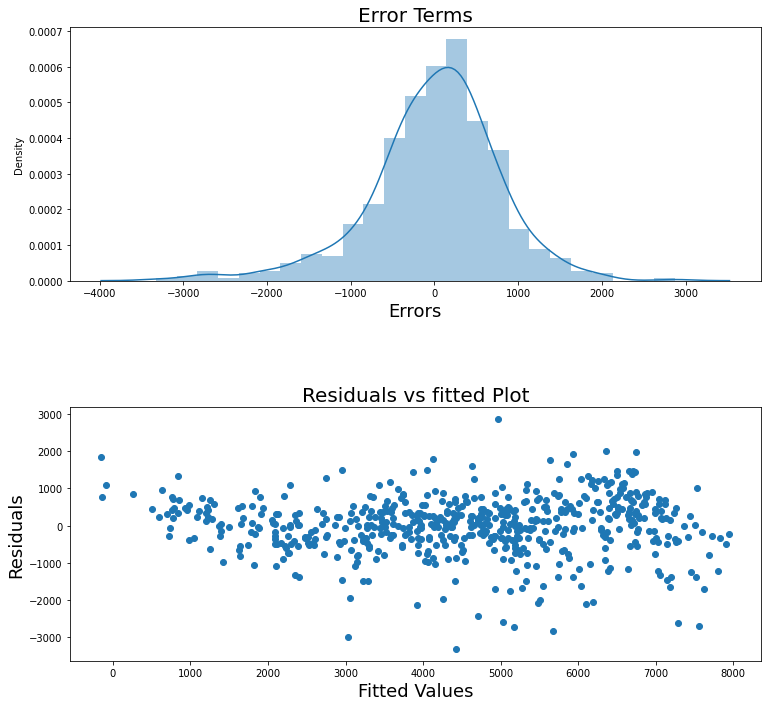

In [51]:
y_predict = lm1.predict(X_train1)

# Plot the histogram of the error terms
fig, axs = plt.subplots(2,1,figsize=(12,8))
axs= axs.flatten()
sns.distplot((y_train - y_predict), bins = 25, ax=axs[0])
axs[0].set_title('Error Terms', fontsize = 20)                  # Plot heading 
axs[0].set_xlabel('Errors', fontsize = 18)                         # X-label
axs[1].scatter(y_predict,(y_train - y_predict))
axs[1].set_xlabel('Fitted Values', fontsize = 18)   
axs[1].set_ylabel('Residuals', fontsize = 18)   
axs[1].set_title('Residuals vs fitted Plot', fontsize = 20)    
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=-0.2,hspace=0.5, wspace=0.5)
plt.savefig('test.png', bbox_inches='tight')

-------------------------------------------------------------------------------------
<font color="green">**Insights**</font>
1. The assumptions that the errors are normally distributed is validated.
2. There are no evident pattern in errors.
-------------------------------------------------------------------------------------

## 8. Model Evaluation

We test our final model with test data.

In [52]:
# Scale the data first.
df_test[numcols] = scaler.transform(df_test[numcols])

# Add constant
df_test = sm.add_constant(df_test)
y_test = df_test['User_Demand']


In [53]:
# We predict the the result of the test set 
X_test = df_test[X_train1.columns]
y_pred = lm1.predict(X_test)


In [54]:
print(f'Model Tested\nr2_Score = {r2_score(y_test, y_pred):0.3f}\nMean Squared Error = {mean_squared_error(y_test, y_pred):0.0f}')

Model Tested
r2_Score = 0.770
Mean Squared Error = 781783


Text(0, 0.5, 'y-predicted')

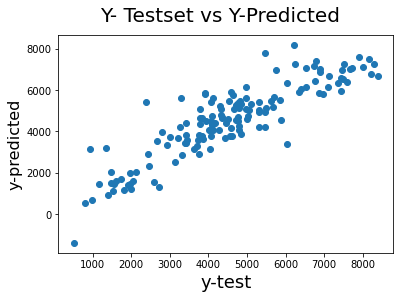

In [55]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('Y- Testset vs Y-Predicted', fontsize = 20)              # Plot heading 
plt.xlabel('y-test', fontsize = 18)                          # X-label
plt.ylabel('y-predicted', fontsize = 16)    

In [56]:
params = lm1.params
params =params.sort_values(ascending=False)
t = [f'{p:0.0f}*{params.index[i]}  ' for i,p in enumerate(params)]
t = '  +  '.join(t)
print('y = '+t)

y = 5347*Temperature    +  1951*Year    +  1869*const    +  1229*Season_Winter    +  778*Month_September    +  723*Season_Summer    +  -402*Month_July    +  -432*Weather_Mist_or_Cloudy    +  -918*Holiday    +  -1564*Humidity    +  -1603*Windspeed    +  -2054*Weather_Light_Rain_or_Snow  


-------------------------------------------------------------------------------------
<font color="green">**Insights**</font><br>
We can see that the equation of our best fitted line is:<br>
    **y = 5347 * Temperature    +  1951 * Year    +  1869 * const    +  1229 * Season_Winter    +  778 * Month_September    +  723 * Season_Summer    +  -402 * Month_July    +  -432 * Weather_Mist_or_Cloudy    +  -918 * Holiday    +  -1564 * Humidity    +  -1603 * Windspeed    +  -2054 * Weather_Light_Rain_or_Snow**


* The Temperature, year and Winter season are the three highest positively affecting Features.
* The Weather Light Rain or Snow and Windspeed are the highest negatively affecting Feature.
-------------------------------------------------------------------------------------
***This indicates that the bike rentals is majorly affected by temperature, Year, season and month. and Weather Harshness***